# Introduction

In this notebook we preprocess a data set of Google Play Store applications and their relevant information. The data set can be found [here](https://www.kaggle.com/lava18/google-play-store-apps)

In [ ]:
import pandas as pd
df = pd.read_csv('googleplaystore.csv')

# Dataset exploration and modification

## Data types

The data set has 13 columns.

App, Category, Type, Content Rating, Genres, Current Ver, and Android Ver are categorical data types

Rating, Reviews, Size, Installs, Price, and Last Updated are numerical data types.

Some columns such as Size and Installs are alphanumeric (e.g. 100k, 200M, 10000+)

From the numeric data, Rating and Price are continual and the rest are discrete

In [ ]:
len(df.columns)

13

In [ ]:
df.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


## Data quality

Analyzing the data set we can see there are several problems. 

First of all we notice that the max rating is listed as 19. This is a mistake in the data set as rating can only go up to 5. This is caused by one row that has its columns shifted to the left.

In [ ]:
df.describe(include = 'all')

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
count,10841,10841,9367.000000,10841,10841,10841,10840,10841,10840,10841,10841,10833,10838
unique,9660,34,NaN,6002,462,22,3,93,6,120,1378,2832,33
top,ROBLOX,FAMILY,NaN,0,Varies with device,"1,000,000+",Free,0,Everyone,Tools,"August 3, 2018",Varies with device,4.1 and up
freq,9,1972,NaN,596,1695,1579,10039,10040,8714,842,326,1459,2451
mean,NaN,NaN,4.193338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.537431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,4.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,4.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.loc[df['Rating'] == 19]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [ ]:
df.drop(index=10472, inplace=True)

Next, we notice a lot of duplicates. These need to be removed.

Apart from completely identical rows, there are some duplicate rows where only the reviews differ. We keep the ones with the most reviews as it is more likely that's the most recent version.

In [ ]:
df.sort_values('Reviews', ascending=False, inplace=True)
df.drop_duplicates(subset='App', keep='first', inplace=True)
df.sort_index(inplace=True)

## Missing values

There are a lot of missing values for the Rating column. Unfortunately we cannot estimate or replace these values so we will have to remove them.

In [ ]:
df.isnull().sum()

App                  0
Category             0
Rating            1463
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

In [ ]:
df.dropna(subset=['Rating', 'Type', 'Current Ver', 'Android Ver'], inplace=True)

In [ ]:
df.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

In [ ]:
df.describe(include="all")

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
count,8190,8190,8190.000000,8190,8190,8190,8190,8190,8190,8190,8190,8190,8190
unique,8190,33,NaN,5319,413,19,2,73,6,115,1299,2625,31
top,FANDOM for: GTA,FAMILY,NaN,2,Varies with device,"1,000,000+",Free,0,Everyone,Tools,"August 3, 2018",Varies with device,4.1 and up
freq,1,1651,NaN,82,1169,1415,7588,7588,6612,717,245,1011,1812
mean,NaN,NaN,4.173162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.536589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,4.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,4.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Sampling

Sampling is often used for two reasons:
- Collecting all the data is too expensive or time consuming
- Analysing the data takes too much computational power

Point one does not apply here, the data has already been collected. Point two can also be ignored because our data set is relatively small, meaning there is no need to sample it

## Dimensionality reduction

### Feature subset selection

There is plenty of irrelevant information in our data set. App name is only an identifier and not important. Current version also tells nothing about the application. We can remove these columns from the data set.

In [ ]:
#Removed 'App' temporarily
df.drop(columns=['Last Updated', 'Current Ver', 'Android Ver'], inplace=True)

## Transformation

The Size column has values in both kilobytes and megabytes. We normalize these to kilobytes and remove the postfix.

We also remove the '$' prefix from the Price column.

In [ ]:
def to_kilobytes(x):
  last_char = x[len(x) - 1]
  value = x[:len(x) - 1]
  if (last_char == 'k'):
    return float(value)
  elif (last_char == 'M'):
    return float(value) * 1000

def remove_dollar(x):
  if (x[0] == '$'):
    return float(x[1:])
  return float(x)

def remove_plus(x):
  return float(x[:len(x) - 1].replace(',', ''))

df['Size'] = df['Size'].apply(to_kilobytes)
df['Price'] = df['Price'].apply(remove_dollar)
df['Reviews'] = pd.to_numeric(df['Reviews'])
df['Installs'] = df['Installs'].apply(remove_plus)

## Feature creation

Apps often have two genres. These are delimited with ';'. New columns can be created to represent a primary genre and a secondary genre.

In [ ]:
df[['Genre 1', 'Genre 2']] = df['Genres'].str.split(';', expand=True)
df.drop(columns=['Genres'], inplace=True)

## Binarization

In our dataset there were only two values in the column Type, so we changed the name to IsFree and binarized the values

In [ ]:
df.loc[df['Type'] == 'Free', 'Type'] = 1
df.loc[df['Type'] == 'Paid', 'Type'] = 0
df.rename(columns={'Type': 'IsFree'}, inplace=True)

Here is a sample of the preprocessed data set

In [ ]:
df.sample(n=30)

,App,Category,Rating,Reviews,Size,Installs,IsFree,Price,Content Rating,Genre 1,Genre 2
3492,myAT&T,PRODUCTIVITY,3.7,80847,NaN,50000000.0,1,0.00,Everyone,Productivity,None
8086,Cy-Reader,FAMILY,4.8,17,15000.0,100.0,1,0.00,Everyone,Education,None
5803,Axe Spinner,FAMILY,3.0,2,NaN,10.0,1,0.00,Everyone,Casual,None
7119,CB Background - Free HD Wallpaper Images,PERSONALIZATION,4.1,4538,3300.0,1000000.0,1,0.00,Everyone,Personalization,None
209,Plugin:AOT v5.0,BUSINESS,3.1,4034,23.0,100000.0,1,0.00,Everyone,Business,None
9601,World Series of Poker – WSOP Free Texas Holdem,GAME,4.5,910051,76000.0,10000000.0,1,0.00,Teen,Card,None
3462,Google Assistant,PRODUCTIVITY,4.2,58675,1300.0,10000000.0,1,0.00,Everyone,Productivity,None
7281,CampGladiator,HEALTH_AND_FITNESS,3.5,293,19000.0,50000.0,1,0.00,Everyone,Health & Fitness,None
10047,Advanced EX for KIA,TOOLS,3.3,257,160.0,5000.0,0,4.99,Everyone,Tools,None
8029,"Hulu: Stream TV, Movies & more",FAMILY,4.0,319777,NaN,10000000.0,1,0.00,Teen,Entertainment,None


# Anomaly detection

In anomaly detection, the goal is to find objects that do
not conform to normal patterns or behavior. Often,
anomalous objects are known as outliers, since, on a
scatter plot of the data, they lie far away from other data
points.

Outliers can have many causes, such as:
- Measurement or input error.
- Data corruption.
- True outlier observation.

Some outliers from input error and data corruption were already removed previously. In this step we are mostly interested in true outlier observation

We import some important libraries that will help us find outliers and plot them.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
sns.set(style="darkgrid", palette="pastel", color_codes=True)
sns.set_context('talk')

## Univariate outliers

Univariate outliers can be found when we look at distribution of a single variable

### Boxplot

A boxplot is a standardized way of displaying the dataset based on the five-number summary: the minimum, the maximum, the sample median, and the first and third quartiles.

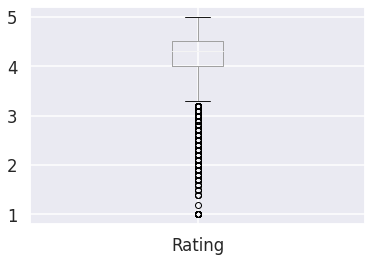

In [ ]:
boxplot = df.boxplot(column=['Rating'])

In [ ]:
ranges = [0,1,2,3,4,5]
df.groupby(pd.cut(df['Rating'], ranges)).count()

,App,Category,Rating,Reviews,Size,Installs,IsFree,Price,Content Rating,Genre 1,Genre 2
Rating,,,,,,,,,,,
"(0, 1]",16,16,16,16,16,16,16,16,16,16,0
"(1, 2]",50,50,50,50,48,50,50,50,50,50,0
"(2, 3]",294,294,294,294,278,294,294,294,294,294,4
"(3, 4]",2061,2061,2061,2061,1836,2061,2061,2061,2061,2061,65
"(4, 5]",5769,5769,5769,5769,4843,5769,5769,5769,5769,5769,312


### Standard deviation

The standard deviation is a measure of the amount of variation or dispersion of a set of values.

In [ ]:
data = df['Price']
data_mean, data_std = data.mean(), data.std()
min_value, max_value = min(data), max(data)
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



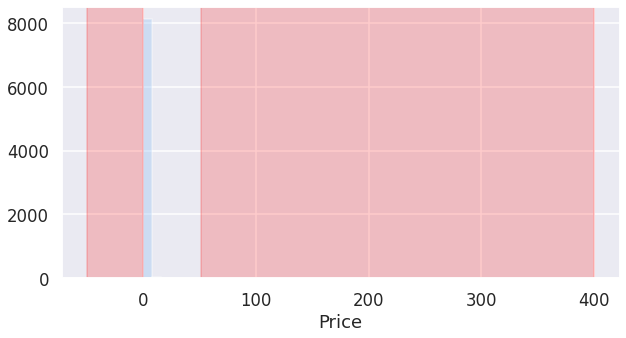

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(df['Price'], kde=False)
plt.axvspan(xmin = lower, xmax = min_value, alpha=0.2, color='red')
plt.axvspan(xmin = upper, xmax = max_value, alpha=0.2, color='red')

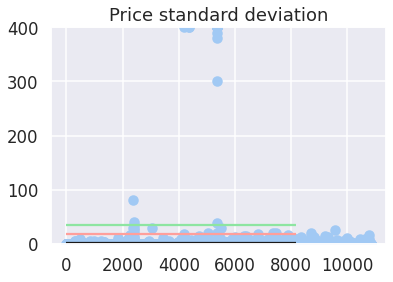

In [ ]:
plt.title("Price standard deviation")
plt.ylim(min_value - 1, max_value + 1)
plt.scatter(x=df.index, y=data)
plt.hlines(y=data_mean, xmin=0, xmax=len(data))
plt.hlines(y=data_mean - data_std, xmin=0, xmax=len(data), colors='r')
plt.hlines(y=data_mean + data_std, xmin=0, xmax=len(data), colors='r')
plt.hlines(y=data_mean - 2 * data_std, xmin=0, xmax=len(data), colors='g')
plt.hlines(y=data_mean + 2 * data_std, xmin=0, xmax=len(data), colors='g')
plt.show()

In [ ]:
df.loc[df['Price'] > 50]

,App,Category,Rating,Reviews,Size,Installs,IsFree,Price,Content Rating,Genre 1,Genre 2
2365,Vargo Anesthesia Mega App,MEDICAL,4.6,92,32000.0,1000.0,0,79.99,Everyone,Medical,None
4197,most expensive app (H),FAMILY,4.3,6,1500.0,100.0,0,399.99,Everyone,Entertainment,None
4362,💎 I'm rich,LIFESTYLE,3.8,718,26000.0,10000.0,0,399.99,Everyone,Lifestyle,None
4367,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7300.0,10000.0,0,400.00,Everyone,Lifestyle,None
5351,I am rich,LIFESTYLE,3.8,3547,1800.0,100000.0,0,399.99,Everyone,Lifestyle,None
5354,I am Rich Plus,FAMILY,4.0,856,8700.0,10000.0,0,399.99,Everyone,Entertainment,None
5355,I am rich VIP,LIFESTYLE,3.8,411,2600.0,10000.0,0,299.99,Everyone,Lifestyle,None
5356,I Am Rich Premium,FINANCE,4.1,1867,4700.0,50000.0,0,399.99,Everyone,Finance,None
5357,I am extremely Rich,LIFESTYLE,2.9,41,2900.0,1000.0,0,379.99,Everyone,Lifestyle,None
5358,I am Rich!,FINANCE,3.8,93,22000.0,1000.0,0,399.99,Everyone,Finance,None


Relation between boxplots and standard deviation

[<img src="https://miro.medium.com/max/700/1*J5Xm0X-phCJJ-DKZMZ_88w.png">]()

### Isolation forest

Isolation forest is an algorithm to detect outliers. It partitions the data using a set of trees and provides an anomaly score looking at how isolated the point is in the structure found. The anomaly score is then used to tell apart outliers from normal observations

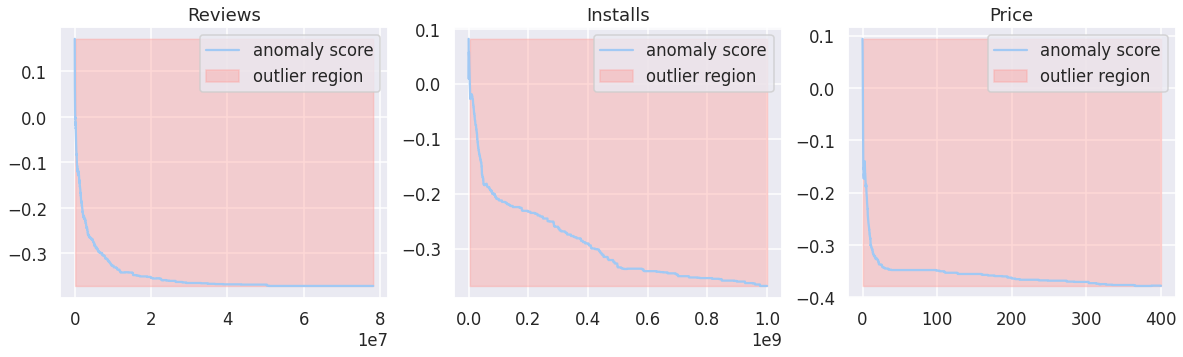

In [ ]:
cols = ['Reviews', 'Installs', 'Price']
#Plotting the sub plot
fig, axs = plt.subplots(1, 3, figsize=(20, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df[column].values.reshape(-1,1))

    xx = np.linspace(df[column].min(), df[column].max(), len(df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

## Multivariate

Multi-variate outliers are outliers in an n-dimensional space. In order to find them, you have to look at distributions in multi-dimensions.

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

This is a clustering algorithm that is similar to k-means clustering. There are two parameters we control here. Eps which is the maximum distance between two samples for them to be considered in the same cluster, and min_samples which is the minimum number of points needed to form a cluster.

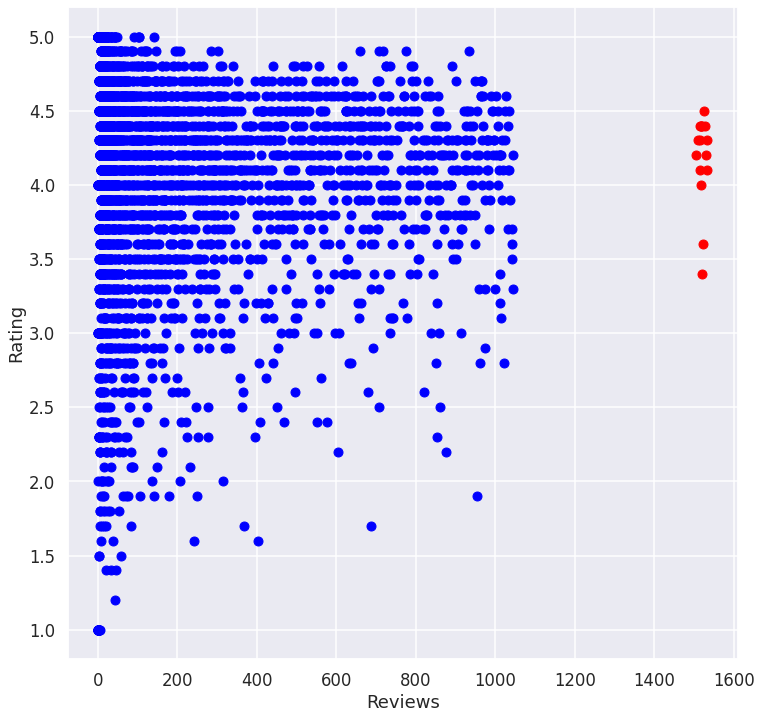

In [ ]:
X = df[['Reviews','Rating']].values

db = DBSCAN(eps=10.0, min_samples=10).fit(X)
labels = db.labels_

plt.figure(figsize=(12,12))

unique_labels = set(labels)
colors = ['blue', 'red']

for color, label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(X[:,0][sample_mask], X[:, 1][sample_mask], 'o', color=color);
plt.xlabel('Reviews');
plt.ylabel('Rating');

### Local Outlier Factor Method(LOF)

LOF is similar to DBSCAN but it looks at outliers in respect to the local neighborhood, not the global dataset.

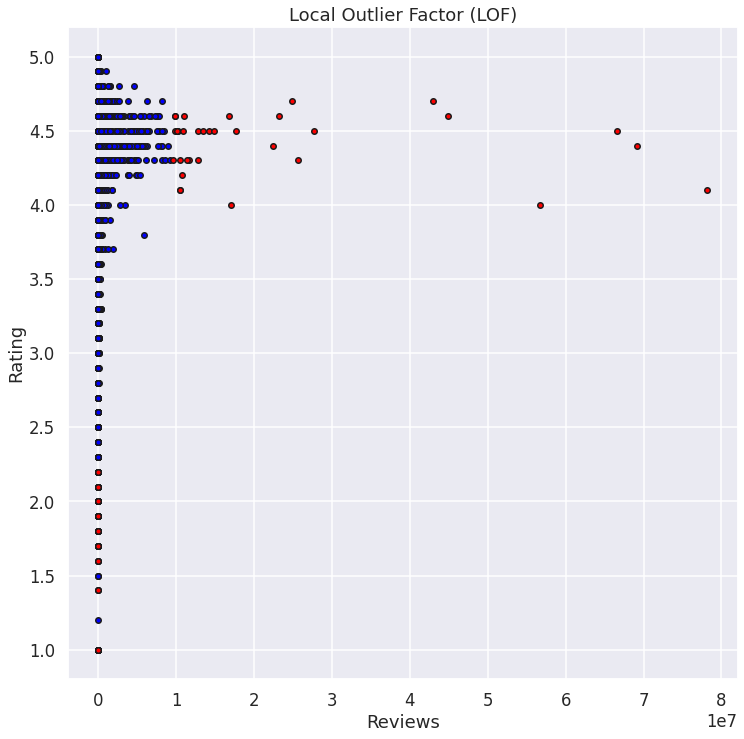

In [ ]:
clf = LocalOutlierFactor(n_neighbors=50, contamination='auto')
X = df[['Reviews','Rating']].values
y_pred = clf.fit_predict(X)

plt.figure(figsize=(12,12))
# plot the level sets of the decision function

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c = 'blue',
                edgecolor = 'k', s = 30)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c = 'red',
                edgecolor = 'k', s = 30)
plt.axis('tight')
plt.xlabel('Reviews');
plt.ylabel('Rating');
plt.show()

# Avoiding false discoveries

Statistical hypothesis testing is a framework for determining whether observed data deviates from what is expected. Statistical hypothesis tests are based a statement called the null hypothesis that assumes nothing interesting is going on between whatever variables you are testing. The purpose of a hypothesis test is to determine whether the null hypothesis is likely to be true given sample data.

In [ ]:
import statistics
import math

## Z-test

A z-test calculates the z-score of a dataset. Simply put, a z-score (also called a standard score) gives you an idea of how far from the mean a data point is. But more technically it’s a measure of how many standard deviations below or above the population mean a raw score is.

**Null Hypothesis**: Reviews do not decrease with less installs

**Alternate Hypothesis**: Reviews decrease with less installs

**Population parameters**: Mean = pop_mean_high, standard deviation = pop_std_high

**Sample parameters**: Mean = sample_mean_low, standard deviation = sample_std_low

In [ ]:
installs_high = df[df.Installs >= 100000]
installs_low = df[df.Installs < 100000]

pop_mean_high = installs_high['Reviews'].mean()
pop_std_high = statistics.stdev(installs_high.Reviews)

installs_low_sample = installs_low.sample(frac=0.10)
sample_mean_low = installs_low_sample['Reviews'].mean()
sample_std_low = statistics.stdev(installs_low_sample.Reviews)

print('Population mean ' + str(pop_mean_high))
print('Population std ' + str(pop_std_high))
print('Sample mean ' + str(sample_mean_low))
print('Sample std ' + str(sample_std_low))
print('Number of rows ' + str(len(installs_low_sample.index)))

Population mean 419058.7739478958
Population std 2531419.09303927
Sample mean 222.7375
Sample std 647.9694155433756
Number of rows 320


In [ ]:
# Confidence Level 95%  for one sided Normal curve
zscore_critical = 1.65 

# Calculate the test statistics 
zscore_test_stat = ((sample_mean_low - pop_mean_high) * math.sqrt(320)) / sample_std_low
print(zscore_test_stat)
print('Null hypothesis is {}'.format(zscore_test_stat >= -zscore_critical and zscore_test_stat <= zscore_critical))

-11562.840176815494
Null hypothesis is False


The z-score falls within the bounds of the z-score critical, meaning our null hypothesis is false. We also check for errors. A type I error occurs when one rejects the null hypothesis when it is true (false positive). A type II error occurs when one rejects the alternative hypothesis (fails to reject the null hypothesis) when the alternative hypothesis is true (false negative).

In [ ]:
pop_mean_low = installs_low['Reviews'].mean()
pop_std_low = statistics.stdev(installs_low.Reviews)

zscore_error = ((pop_mean_low - pop_mean_high)/pop_std_low)
print(zscore_error)

-589.4612027072603


We do not have an error in our hypothesis testing.

[<img src="http://www.cs.uni.edu/~campbell/stat/dn.gif">]()

## T-test

T-tests are closely related to Z-tests with some differences. Z-tests are used when sample size is large, usually over 50 (in our case 320), or the population variance is known (we calculated pop_std). T-tests on the other hand are used for small samples, less than 50, and when the population variance is unknown.

#Data Exploration and Visualisation


## Different groups of Application and the numbers of application

In [ ]:
df['Category'].value_counts().sort_values()

BEAUTY                   42
EVENTS                   45
PARENTING                50
COMICS                   54
ART_AND_DESIGN           58
HOUSE_AND_HOME           61
LIBRARIES_AND_DEMO       63
WEATHER                  72
AUTO_AND_VEHICLES        73
ENTERTAINMENT            86
FOOD_AND_DRINK           94
EDUCATION               107
MAPS_AND_NAVIGATION     118
DATING                  134
VIDEO_PLAYERS           149
BOOKS_AND_REFERENCE     169
SHOPPING                180
TRAVEL_AND_LOCAL        187
SOCIAL                  203
NEWS_AND_MAGAZINES      204
HEALTH_AND_FITNESS      244
COMMUNICATION           256
SPORTS                  260
BUSINESS                263
PHOTOGRAPHY             263
MEDICAL                 290
PERSONALIZATION         296
PRODUCTIVITY            301
LIFESTYLE               301
FINANCE                 302
TOOLS                   718
GAME                    896
FAMILY                 1651
Name: Category, dtype: int64

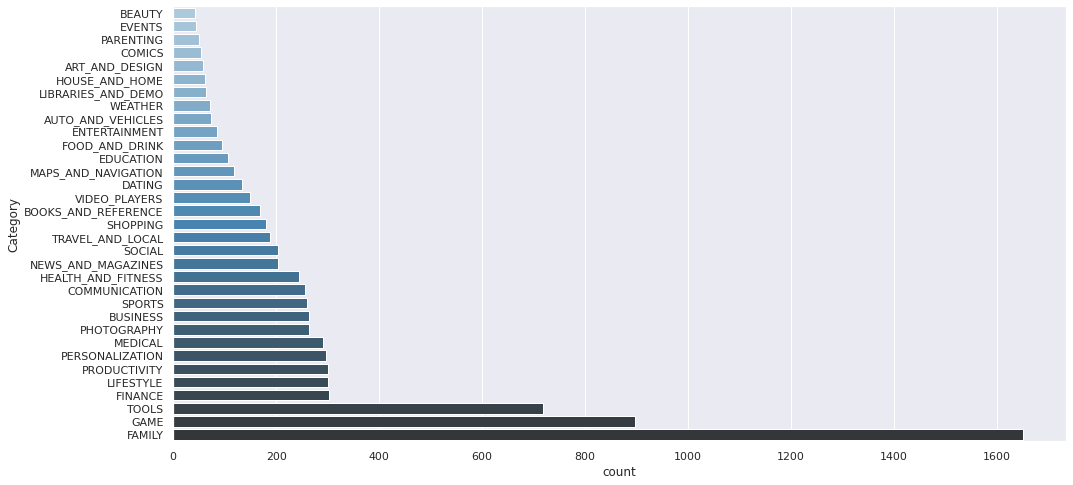

In [ ]:
sns.set(style='darkgrid')
plt.figure(figsize=(16,8))
sns.countplot(y='Category', data=df, palette='Blues_d', order = df['Category'].value_counts().sort_values().index)

### Free/Paid Apps in Google Play Store

Below we will visualize the percentage representation of free versus paid apps in Google Play Store.

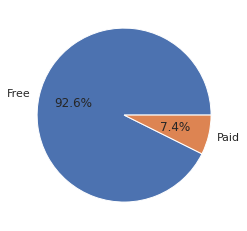

In [ ]:
x= df.IsFree.value_counts()
label= ["Free","Paid"]
plt.pie(x,labels= label,autopct= "%1.1f%%")
plt.show()

## Fields analysis - using matplotlib

### Rating

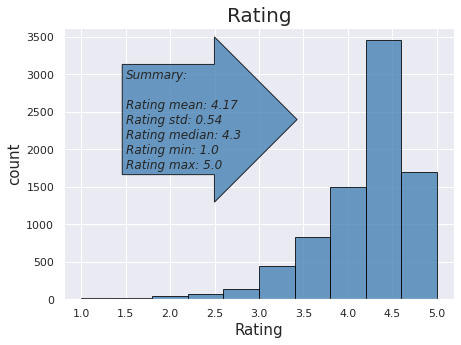

In [ ]:
plt.figure(figsize = (7,5))
plt.hist(df['Rating'], alpha=0.8, histtype='bar', color='steelblue', edgecolor='black')
plt.xlabel("Rating", size = 15)
plt.ylabel("count", size = 15)
plt.title("Rating",size = 20)
Rm = round(df['Rating'].mean(), 2)
Rsd = round(df['Rating'].std(), 2)
Rmo = round(df['Rating'].median(), 2)
Rmin = round(df['Rating'].min(), 2)
Rmax = round(df['Rating'].max(), 2)

txt = f"Summary:\n\nRating mean: {Rm}\nRating std: {Rsd}\nRating median: {Rmo}\nRating min: {Rmin}\nRating max: {Rmax}"
plt.text(1.5, 1750,txt,size=12,style = 'italic',bbox=dict(facecolor='steelblue',alpha=0.8, edgecolor='black', boxstyle='rarrow,pad=0.3'))
plt.show()

### Category

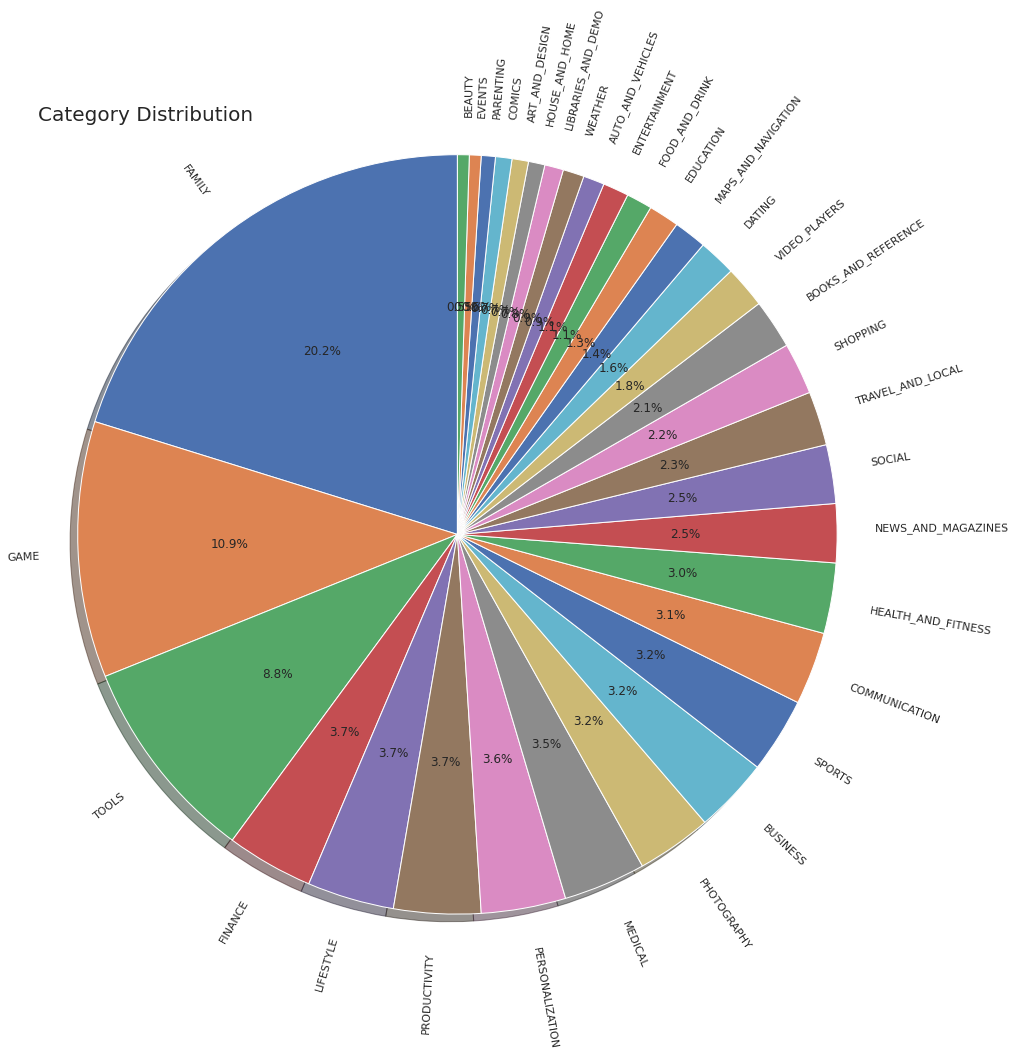

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = df['Category'].value_counts().index.tolist()
sizes = [round(item,3) for item in list(df['Category'].value_counts()/df.shape[0])]
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize = (15,15))
ax1.pie(sizes , labels=labels, rotatelabels=True,autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')# Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Category Distribution",size = 20,loc = "left")
plt.show()

### Reviews

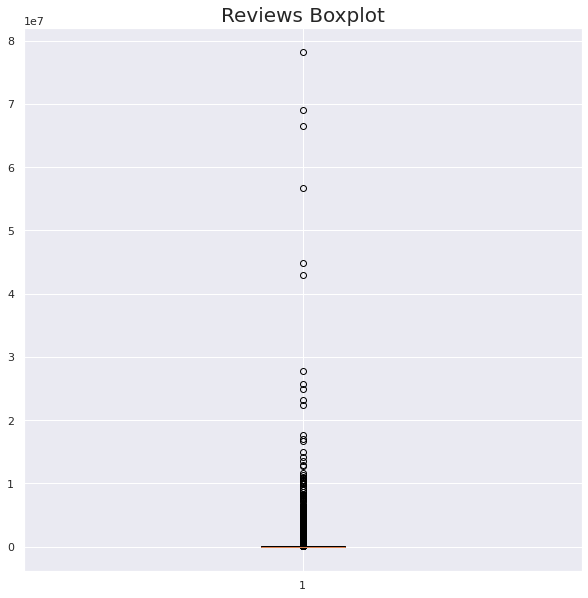

In [ ]:
fig1, ax1 = plt.subplots(figsize = (10,10))
ax1.set_title('Reviews Boxplot', size = 20)
ax1.boxplot(df['Reviews'])
plt.show()

{'boxes': [<matplotlib.patches.PathPatch at 0x7f0d37653b50>],
 'caps': [<matplotlib.lines.Line2D at 0x7f0d37632190>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0d394391d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f0d37632c10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f0d3764b990>,
  <matplotlib.lines.Line2D at 0x7f0d3764b410>]}

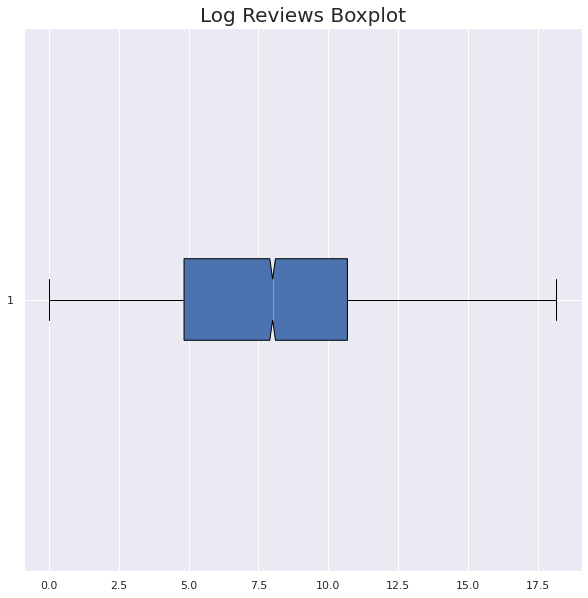

In [ ]:
fig1, ax1 = plt.subplots(figsize = (10,10))
ax1.set_title('Log Reviews Boxplot', size = 20)
ax1.boxplot(np.log(df['Reviews']),notch = True,vert=False,patch_artist=True)

### Size

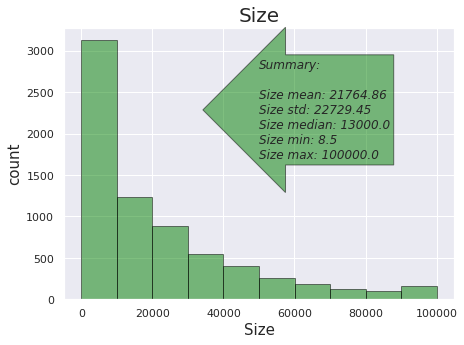

In [ ]:
plt.figure(figsize = (7,5))
plt.hist(df['Size'], alpha=0.5, histtype='bar', color='green', edgecolor='black')
plt.xlabel("Size", size = 15)
plt.ylabel("count", size = 15)
plt.title("Size", size = 20)
Sm = round(df['Size'].mean(), 2)
Ssd = round(df['Size'].std(), 2)
Smo = round(df['Size'].median(), 2)
Smin = round(df['Size'].min(), 2)
Smax = round(df['Size'].max(), 2)

txt = f"Summary:\n\nSize mean: {Sm}\nSize std: {Ssd}\nSize median: {Smo}\nSize min: {Smin}\nSize max: {Smax}"
plt.text(50000, 1700,txt,size=12,style = 'italic',bbox=dict(facecolor='green',alpha=0.5, edgecolor='black', boxstyle='larrow,pad=0.3'))
plt.show() 

### Price

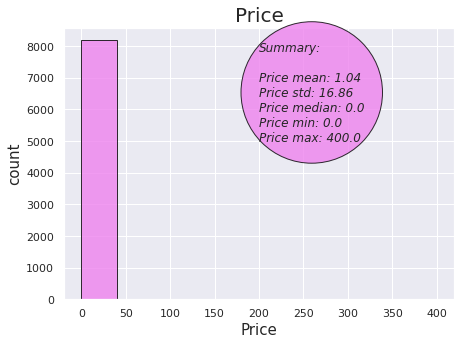

In [ ]:
plt.figure(figsize = (7,5))
plt.hist(df['Price'], alpha=0.8, histtype='bar', color='violet', edgecolor='black')
plt.xlabel("Price", size = 15)
plt.ylabel("count", size = 15)
plt.title("Price", size = 20)
Pm = round(df['Price'].mean(), 2)
Psd = round(df['Price'].std(), 2)
Pmo = round(df['Price'].median(), 2)
Pmin = round(df['Price'].min(), 2)
Pmax = round(df['Price'].max(), 2)

txt = f"Summary:\n\nPrice mean: {Pm}\nPrice std: {Psd}\nPrice median: {Pmo}\nPrice min: {Pmin}\nPrice max: {Pmax}"
plt.text(200, 5000,txt,size=12,style = 'italic',bbox=dict(facecolor='violet',alpha=0.8, edgecolor='black', boxstyle='circle,pad=1.5'))
plt.show()

### Content Rating

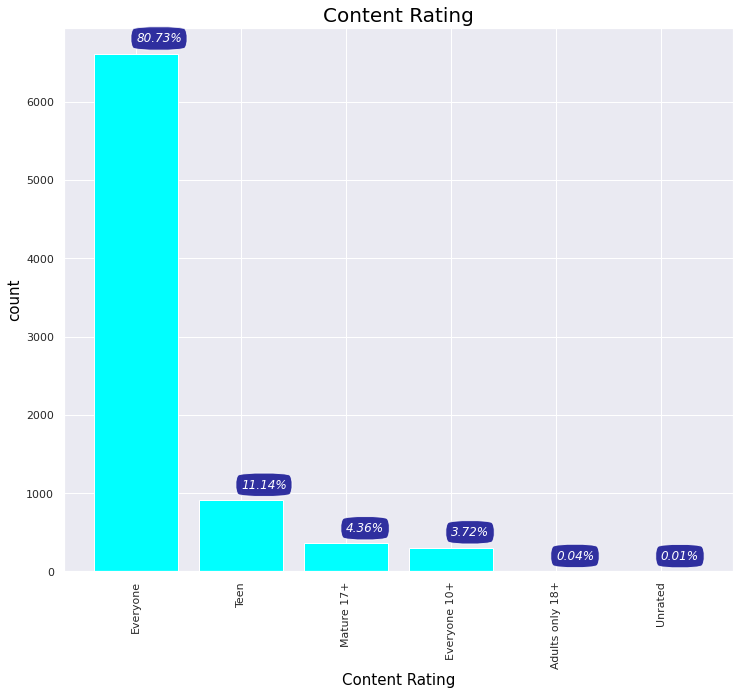

In [ ]:
plt.figure(figsize = (12,10))
plt.bar(df['Content Rating'].value_counts().index.tolist(),df['Content Rating'].value_counts(), color = "cyan")
plt.xticks(rotation=90)
for i in range(len(df['Content Rating'].value_counts())):
    txt = f"{round(df['Content Rating'].value_counts()[i]/df.shape[0]*100,2)}%"
    plt.text(i, df['Content Rating'].value_counts()[i]+150,txt,size=12,style = 'italic',color = "white",bbox=dict(facecolor='darkblue',alpha=0.8, edgecolor='white', boxstyle='round4,pad=0.5'))
plt.xlabel("Content Rating",size = 15, color = "black")
plt.ylabel("count",size = 15, color = "black")
plt.title("Content Rating",size = 20, color = "black")
plt.show()

## Fields Multivariate analysis - using seaborn 

### Considering reviews and ratings, Which factor has more impact on the number of installations?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Number of Reviews (Log scaled) Vs Number of Downloads (Log scaled)')

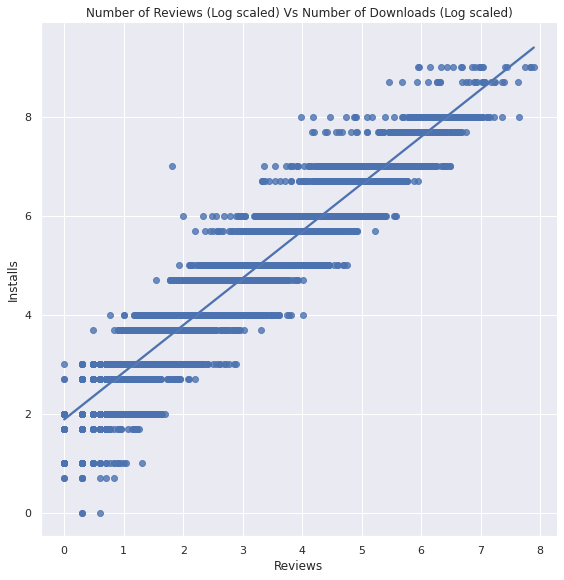

In [ ]:
df_copy = df.copy()

df_copy = df_copy[df_copy.Reviews > 0]
df_copy = df_copy[df_copy.Installs > 0]

df_copy['Installs'] = np.log10(df['Installs'])
df_copy['Reviews'] = np.log10(df['Reviews'])


sns.lmplot("Reviews", "Installs", data=df_copy, height=8, aspect=1)
plt.title('Number of Reviews (Log scaled) Vs Number of Downloads (Log scaled)')
# ax = plt.gca()

# _ = ax.set_title('Number of Reviews (Log scaled) Vs Number of Downloads (Log scaled)')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



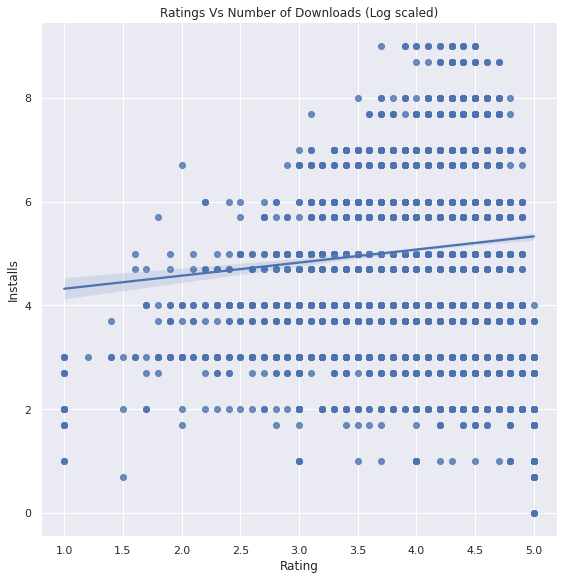

In [ ]:
df_copy = df.copy()

df_copy = df_copy[df_copy.Rating > 0]
df_copy = df_copy[df_copy.Installs > 0]

df_copy['Installs'] = np.log10(df['Installs'])
df_copy['Rating'] = (df['Rating'])


sns.lmplot("Rating", "Installs", data=df_copy, height=8, aspect=1)

ax = plt.gca()

_ = ax.set_title('Ratings Vs Number of Downloads (Log scaled)')

In [ ]:
df_copy.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'IsFree',
       'Price', 'Content Rating', 'Genre 1', 'Genre 2'],
      dtype='object')

In [ ]:
df_copy.drop(['App', 'Category','Size', 'IsFree', 'Price'], axis=1, inplace=True)

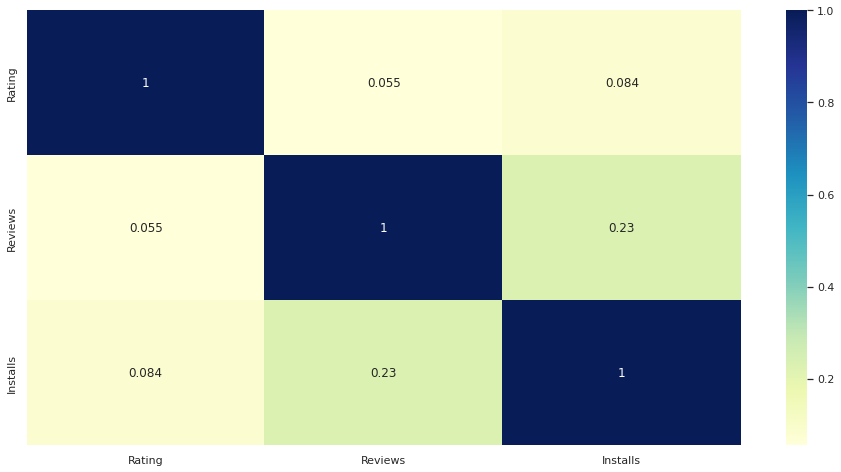

In [ ]:
plt.figure(figsize=(16,8))
p = sns.heatmap(df_copy.corr(), annot=True, cmap="YlGnBu")

*Reviews has more impact on the number of Installs than Ratings*

### Does size impact installs and ratings?

In [ ]:
# df_copy2 = df.copy()

In [ ]:
df.sample(2)

,App,Category,Rating,Reviews,Size,Installs,IsFree,Price,Content Rating,Genre 1,Genre 2
2740,Nordstrom,SHOPPING,4.6,2278,12000.0,500000.0,1,0.0,Everyone,Shopping,None
2729,Coupons.com – Grocery Coupons & Cash Back Savings,SHOPPING,4.2,24953,NaN,1000000.0,1,0.0,Everyone,Shopping,None


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 10840
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             8190 non-null   object 
 1   Category        8190 non-null   object 
 2   Rating          8190 non-null   float64
 3   Reviews         8190 non-null   int64  
 4   Size            7021 non-null   float64
 5   Installs        8190 non-null   float64
 6   IsFree          8190 non-null   object 
 7   Price           8190 non-null   float64
 8   Content Rating  8190 non-null   object 
 9   Genre 1         8190 non-null   object 
 10  Genre 2         381 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 1.1+ MB


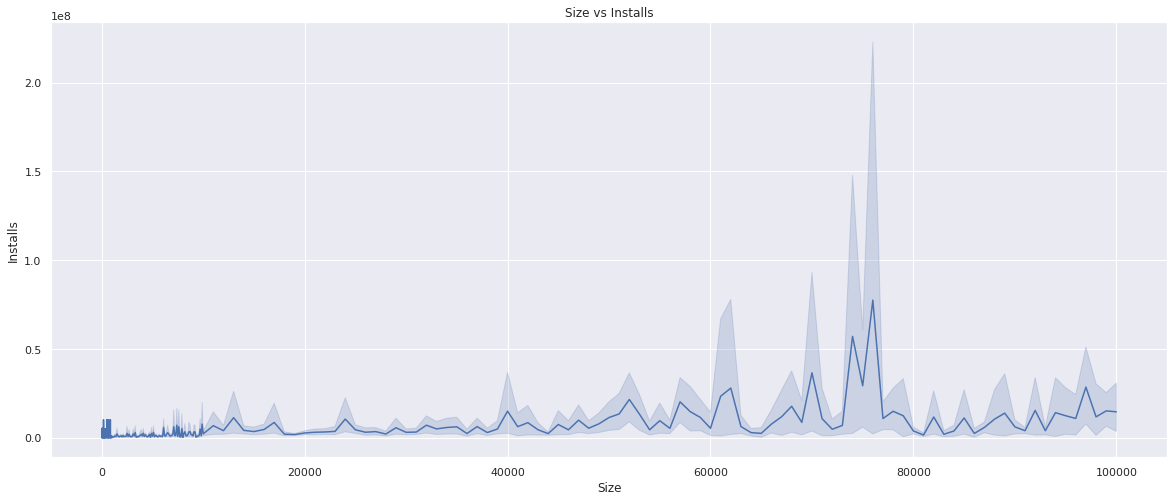

In [ ]:
sns.set_style('ticks')
sns.set_style("darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
ax = sns.lineplot(x='Size', y='Installs', data=df)
title = ax.set_title('Size vs Installs')

*As we can see from the graph representation Size between 60-80 interval has the most Installs*

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



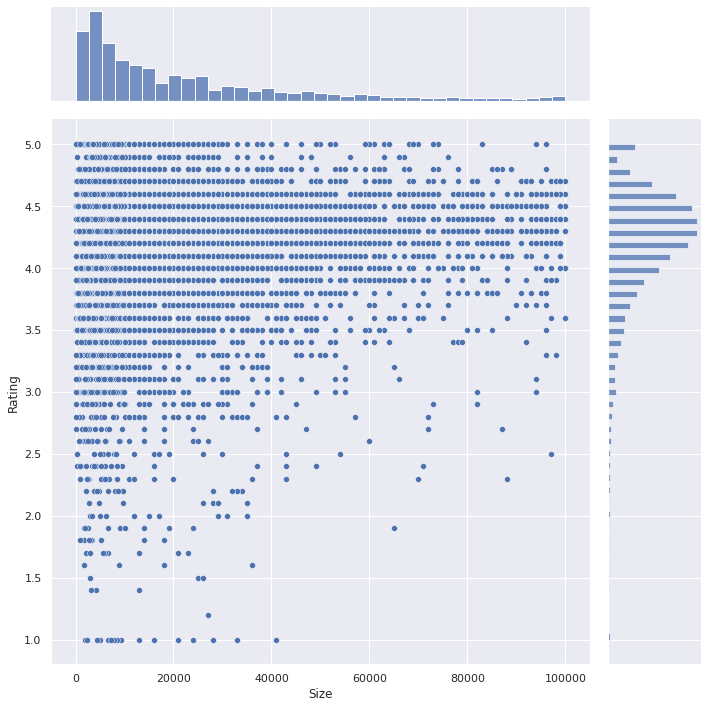

In [ ]:
sns.set_style("darkgrid")
ax = sns.jointplot(df['Size'], df['Rating'], height = 10)

*Ratings varies a lot on size but the size between 1 - 40 MB is pretty good*

## Ratings of Free/Paid apps

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0.98, 'Ratings of Paid Apps')

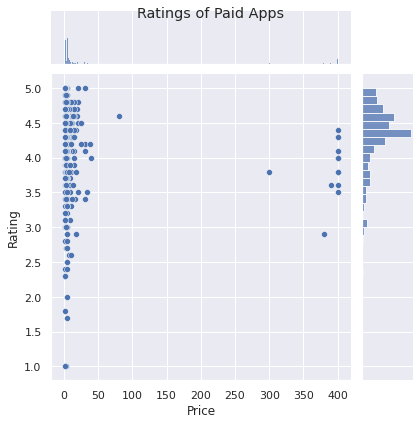

In [ ]:
paid_apps = df[df.Price>0]
p = sns.jointplot("Price", "Rating", paid_apps)
p.fig.suptitle("Ratings of Paid Apps")

*Price between 1-35$ have good ratings*

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0.98, 'Ratings of Free Apps')

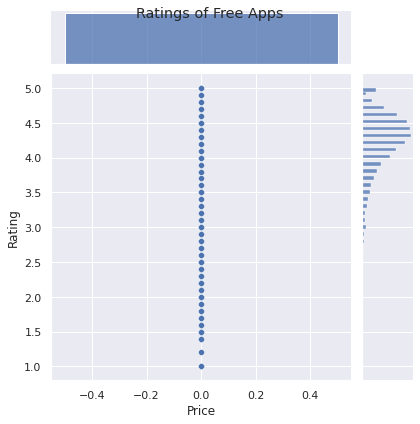

In [ ]:
free_apps = df[df.Price==0]
p = sns.jointplot("Price", "Rating", free_apps)
p.fig.suptitle("Ratings of Free Apps")

In [ ]:
import plotly.graph_objs as go
import plotly
g1 = go.Box(
    y=(df['Rating'][df.IsFree==0]),
    name = 'Paid',
    marker = dict(
        color = 'rgb(0,0,0)',
    )
)
g2 = go.Box(
    y=(df['Rating'][df.IsFree==1]),
    name = 'Free',
    marker = dict(
        color = 'rgb(255,0,120)',
    )
)
layout = go.Layout(
    title = "Ratings of paid apps Vs free apps",
    yaxis= {'title': 'Ratings'}
)
data = [g1, g2]
plotly.offline.iplot({'data': data, 'layout': layout})
print("Mean of the ratings(Free type): " + str(df['Rating'][df.IsFree==1].mean()))
print("Mean of the ratings(Paid type): " + str(df['Rating'][df.IsFree==0].mean()))

Mean of the ratings(Free type): 4.16628887717449
Mean of the ratings(Paid type): 4.259800664451825


*Ratings is not so much different, but free apps have more outliers.*

## EDA 

Creating Hypotheses, testing various business assumptions while dealing with any Machine learning problem statement is very important and this is what EDA helps to accomplish. There are various tootle and techniques to understand your data, And the basic need is you should have the knowledge of Numpy for mathematical operations and Pandas for data manipulation.

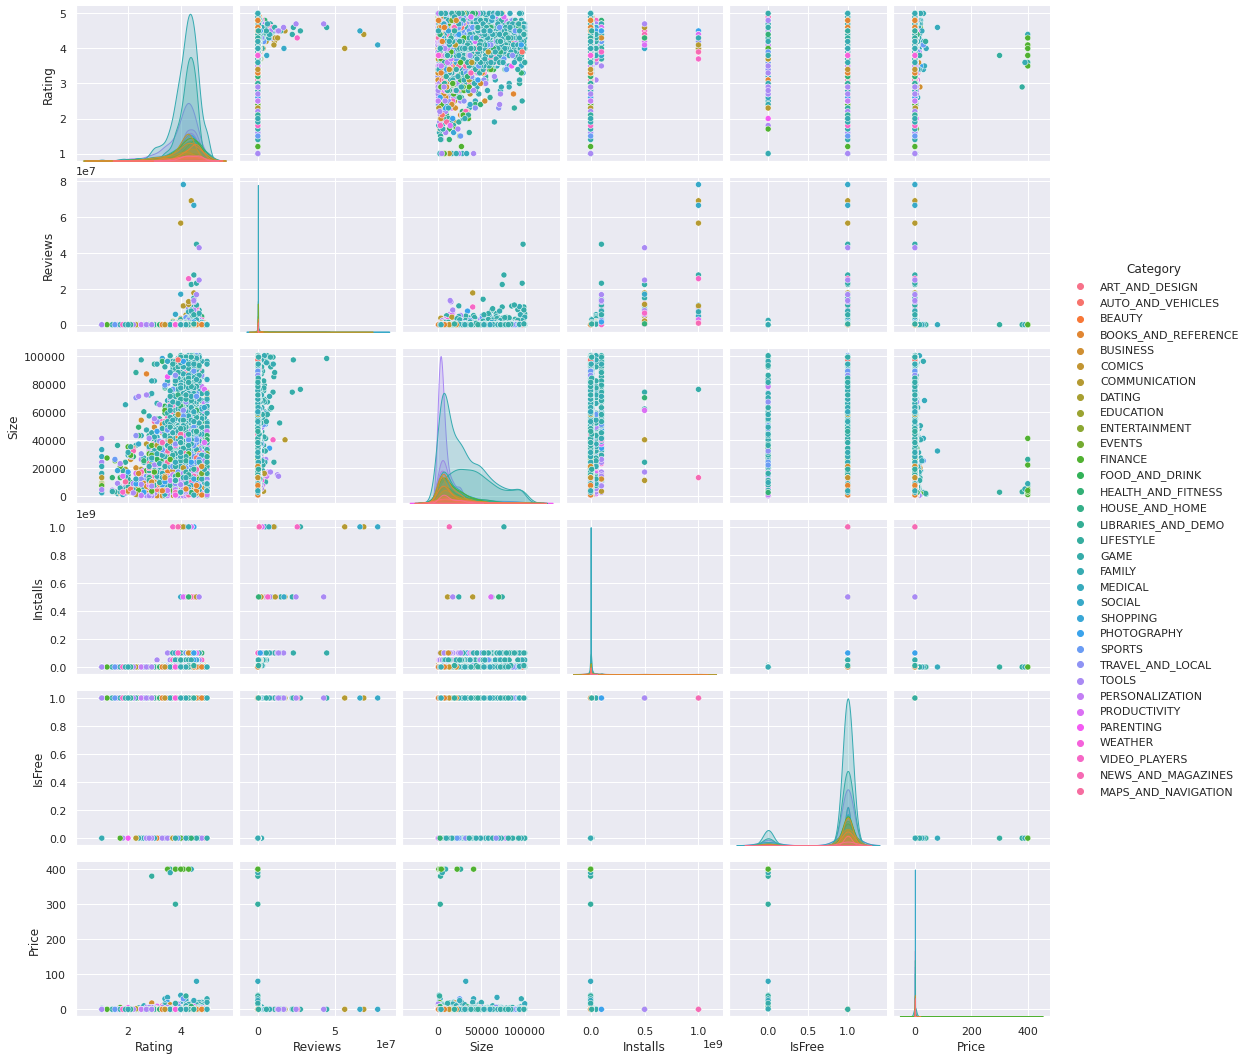

In [ ]:
sns.pairplot(data = df,hue = 'Category')